



Importamos funciones

### Nota:
El documento está dividido en 2 partes. La primera es una implementación del algoritmo basado en un paper en donde se generaban grafos aleatoriamente. La segunda es una implementación del equipo UC-COVID en donde se implementa esta misma función, pero basada en ideas propias y bases de datos de redes de calles de USA.

# Parte 1

In [1]:
import os
import sys
#from ipynb.fs.full.Robustez import get_size_robust
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

In [2]:
from collections import deque
import random

Leemos grafo

In [14]:
path_geom = '../data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path_geom, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
     
path = '../data/corrected_dijkstra.csv'
path = path_geom
csv_grafo = pd.read_csv(path, sep=';') #, sep=','

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

Tree = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        Tree.add_edge(id_[origin], id_[dest])
        
G_SP = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G_SP.add_edge(id_[origin], id_[dest])
    
N = l

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

Obtenemos carácterísticas del grafo

## Algoritmo
Parámetros iniciales

In [4]:
J = N
J = 30 # N
O = deque([0], int(1e6)) #0 es WTF
S = 0
#F_l = #largo de calles
#P_n = # cantidad de salidas desde el nodo
G = nx.DiGraph()
l = 0

Main loop

In [5]:
while True:
    # Parámetros
    J = N
    J = 40 # N
    O = deque([0], int(1e4)) #0 es WTF
    S = 0
    F_l = list(range(1,6)) # Largo de las calles
    P_n = [1, 1, 1, 1, 2, 2, 3, 3, 4] # cantidad de salidas desde el nodo
    G = nx.DiGraph()
    l = 0
    
    # Main loop
    while O: 
        # nts: next_tree_segment
        nts = O.popleft()
        growth = random.choice(P_n) 
        lenght_ = random.sample(F_l, growth)
        
        for i in range(1, growth + 1):
            G.add_edge(l + i, nts, length = lenght_[i - 1])
            O.append(l+i)
            
        l += growth
        S += growth
        
        
        if S >= J:
            break
    
    if len(G.nodes()) > J:
        break

In [6]:
len(G.nodes())

41

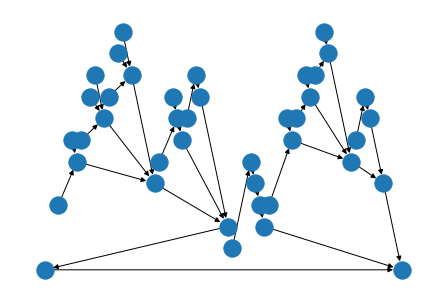

In [7]:
layout = nx.planar_layout(G)
nx.draw(G, pos = layout, with_labels = False )

In [8]:
max_depth = 15
T = Tree.subgraph([node for node in list(Tree.nodes()) if nx.shortest_path_length(Tree, source = node, target = 744) <= max_depth])
print(len(T.nodes()))

42


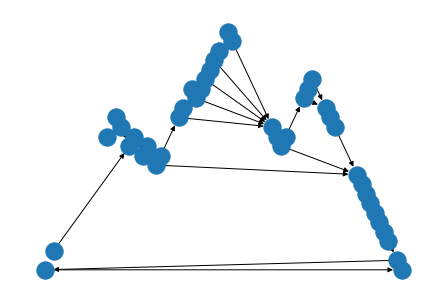

In [9]:
layout = nx.planar_layout(T)
nx.draw(T, pos = layout, with_labels = False )

# Parte 2
## USA data
### Algoritmo propio

Leemos grafo desde base de datos

In [3]:
path_nodes = '../data_random/TG.txt'
nodes_location = pd.read_csv(path_nodes, sep=" ", header=None, names = ['ID', 'Longitude', 'Latitude'])
path_edges = '../data_random/TG_edge.txt'
edges_location = pd.read_csv(path_edges, sep=" ", header=None, names = ['edge_ID', 'ID_1', 'ID_2', 'Distance'])
edges_location.head()

,edge_ID,ID_1,ID_2,Distance
0,0,0,7388,1.410871
1,1,0,5744,1.069441
2,2,0,5835,34.071991
3,3,0,3647,14.796446
4,4,1,4232,136.073166


### Pendiente:  Agregar tapas capa D distancia

In [4]:
S = set()
for index, row in edges_location.iterrows():
    origin = row['ID_1']
    dest = row['ID_2']
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

        
G_SJ = nx.Graph()
for index, row in edges_location.iterrows():
    origin = row['ID_1']
    dest = row['ID_2']
    G_SJ.add_edge(id_[origin], id_[dest])
    
N_ = l

Ploteamos el grado de los nodos del grafo

<AxesSubplot:>

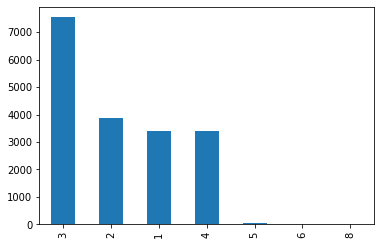

In [5]:
freq = [len(list(G_SJ.neighbors(i) )) for i in range(len(G_SJ.nodes()))]
pd.Series(freq).value_counts().plot(kind='bar')

Función get_closest retorna los $q$ nodos más cercanos al grafo que sean vecinos en el grafo original

In [6]:
def by_distance(element):
    return element[1]


def get_closest(G, locations, node, q):
    # get position of node
    x = locations[locations['ID'] == _id[node]]['Longitude'].iloc[0]
    y = locations[locations['ID'] == _id[node]]['Latitude'].iloc[0]
    
    #Neighbors
    ng = list(G.neighbors(node))
    
    # Calculate distances
    distances = list()
    for n in ng:
        n_id = _id[n]
        x_row = locations[locations['ID'] == n_id]['Longitude'].iloc[0]
        y_row = locations[locations['ID'] == n_id]['Latitude'].iloc[0]
        d = (x - x_row)**2 + (y - y_row)**2
        distances.append((n, d))
    
    # Order by distance and return q closest
    distances.sort(key = by_distance)    
    return [i[0] for i in distances[:q]] 

get_random_tree recibe un grafo G y una cantidad de nodos y retorna un árbol. Para esto hace una especie de bfs en donde se le hace un shuffle en cada iteración a la cola de hijos. De está forma se van agregando nodos hasta cumplir el límite.

add_extra_edges agrega aristas extras que perturban un árbol. Para esto selecciona al azar cierta cantidad de nodos y si se puede y no se supera el edge limit entonces agrega aristas que estaban en el grafo original G pero no en árbol T. De lo contrario selecciona otro nodo para esto.

In [7]:
def get_random_tree(G, nodes):
    new_G = nx.DiGraph()
    N = len(G.nodes())
    WTP = random.choice(list(G.nodes()))
    V = [0] * N;  V[WTP] = 1
    Q = deque([]); Q.append(WTP)
    while Q:
        if len(new_G.nodes()) < nodes:
            random.shuffle(Q)
            u = Q.popleft()
            for v in G.neighbors(u):
                if not V[v]:
                    Q.append(v)
                    new_G.add_edge(v,u)
                    V[v] = 1
        else:
            break
    return new_G, WTP

def add_extra_edges(T, G, locations, ratio, edge_limit):
    nodes = list(T.nodes())
    counter = 0
    perturbed = random.choices(nodes, k = math.ceil(len(nodes) * ratio))
    for node in perturbed:
        added = False
        if len(list(T.predecessors(node))) < edge_limit:
            closest = [i for i in get_closest(G, locations, node, 7) if i in nodes]
            if closest:
                closest = closest[0]
                T_neigbors = list(T.predecessors(node)) + list(T.successors(node))
                if len(list(T.predecessors(closest))) < edge_limit and  closest not in T_neigbors:
                    T.add_edge(node, closest)
                    added = True
                    #print('added')
        if not added and counter < len(nodes):
            perturbed.append(random.choice(nodes))
            counter += 1
    return T


In [8]:
def generate_random_graph(G, nodes, locations, ratio, edge_limit):
    T, WTP = get_random_tree(G, nodes)
    NG = add_extra_edges(T,G, locations, ratio, edge_limit)
    return NG, WTP
        

Ejemplos

10

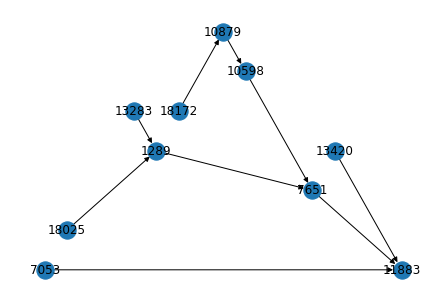

In [9]:
#U = nx.complete_graph(8)

G = G_SJ

R, _ = get_random_tree(G_SJ, 10)
R = add_extra_edges(R,G, nodes_location, 0.4, 5)
layout = nx.planar_layout(R)
nx.draw(R, pos = layout, with_labels = True)
len(R.nodes())

10

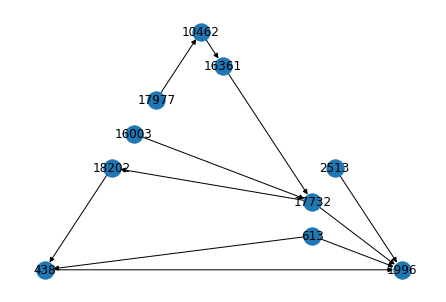

In [10]:
G_ , _ = generate_random_graph(G_SJ, 10, nodes_location, 0.5, 4)
layout = nx.planar_layout(G_)
nx.draw(G_, pos = layout, with_labels = True)
len(G_.nodes())

## Visualización de resultados

In [11]:
from shapely.geometry import LineString, Point

In [12]:
# geometry.head()
edges_location.head()

,edge_ID,ID_1,ID_2,Distance
0,0,0,7388,1.410871
1,1,0,5744,1.069441
2,2,0,5835,34.071991
3,3,0,3647,14.796446
4,4,1,4232,136.073166


Primero obtenemos localizaciones de cada nodo y los asociamos a sus respectivas aristas

In [13]:
def get_location_node(locations, node):
    x = locations[locations['ID'] == node]['Longitude'].iloc[0]
    y = locations[locations['ID'] == node]['Latitude'].iloc[0]
    return x,y

def create_linestring(row, locations):
    node_1 = row['ID_1']
    node_2 = row['ID_2']
    x_1, y_1 = get_location_node(locations, node_1)
    x_2, y_2 = get_location_node(locations, node_2)
    return LineString([ (x_1, y_1) , (x_2, y_2)])

Asignamos geometría a la base de datos de aristas. Las columnas de 'edge' y 'edge_' son tentativas para visualizar resultados, pero aún no se les da utilidad, por lo que eventualmente se podrían borrar.

In [14]:
edges_location['geometry'] = edges_location.apply(lambda row: create_linestring(row, nodes_location), axis = 1)

In [15]:
edges_location.head()

,edge_ID,ID_1,ID_2,Distance,geometry
0,0,0,7388,1.410871,"LINESTRING (2418.382812 689.4497679999999, 241..."
1,1,0,5744,1.069441,"LINESTRING (2418.382812 689.4497679999999, 241..."
2,2,0,5835,34.071991,"LINESTRING (2418.382812 689.4497679999999, 238..."
3,3,0,3647,14.796446,"LINESTRING (2418.382812 689.4497679999999, 241..."
4,4,1,4232,136.073166,"LINESTRING (5983.526367 3650.609131, 6024.6494..."


In [16]:
# edges_location['edge'] = edges_location.apply(lambda row: (row['ID_1'], row['ID_2']), axis=1 )
# edges_location['edge_'] = edges_location.apply(lambda row: (row['ID_2'], row['ID_1']), axis=1 )

In [17]:
edges_location.head()
df = gpd.GeoDataFrame(edges_location['geometry'])

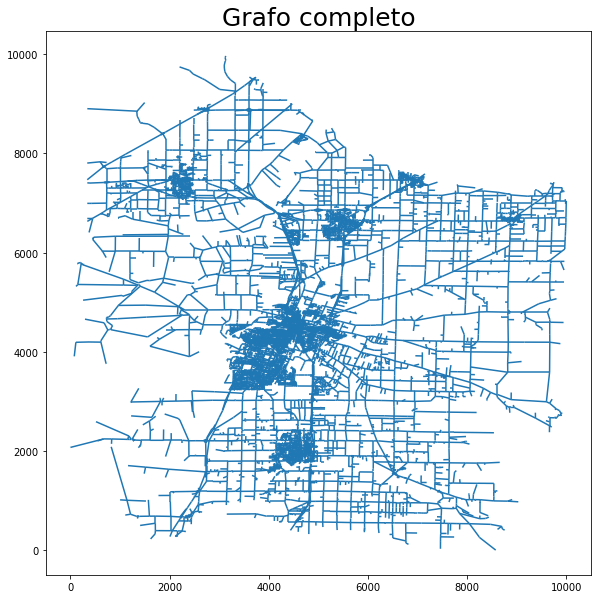

In [18]:
f, ax = plt.subplots(figsize=(10,10 ))
ax.set_title("Grafo completo", fontsize=25)
ax = df.plot(ax = ax, 
                   figsize=(10, 10),
                   legend = True)

plt.show()

### Nota: 
plot_random_graph grafica uno de los grafos generados. Se tiene una lista de  G_id1 = [edge[0] for edge in G.edges()] que representa a todos los 'u' y otra lista análoga que representa a todos los 'v'. Luego se filtran todas las aristas que tienen a ambos nodos en una de las dos listas. 

El problema es que existen aristas que pertenecen a al grafo original pero no al generado aleatoriamente que cumplen con esto, por lo que se grafican ciclos. He intentado filtrarlo de diferentes formas, pero por Pandas no lo he logrado por errores (asumo) del código de ellos que no me deja tomar dos columnas diferentes y manipularlas (aunque una sí se puede).

In [74]:
def filter_(G, row):
    return row['edge'].isin(list(G.edges() )) #or row['edge_'].isin(list(G.edges() )) 


def plot_random_graph(G, edges_location, nodes_location, WTP):
    # Armamos listas de extremos de vertices
    G_id1 = [edge[0] for edge in G.edges()]
    G_id2 = [edge[1] for edge in G.edges()]
    #d = {(u,v) for u,v in G.edges()}
    pd.options.mode.chained_assignment = None  # default='warn'
    filtered = edges_location.loc[(edges_location['ID_1'].isin(G_id1)) & (edges_location['ID_2'].isin(G_id2))]

    # Filtramos elementos que están contenidos
    #filtered = edges_location.loc[lambda row: filter_(G, row) ]

    #filtered = edges_location.loc[edges_location['edge'] in d ]
    #filtered = filtered[(filtered['edge'] in d) & (filtered['edge_'] in d)]
    
    filtered.loc[filtered.shape[0] + 1] = ['WTP'] + ['WTP'] + ['WTP'] + ['WTP'] + [Point(get_location_node(nodes_location, WTP), 10)] 

# PLOT NODES
#     nodes = list(G.nodes())
#     for i in range(len(G.nodes())):
#         node = nodes[i]
#         if node in list(filtered['ID_1']) or node in list(filtered['ID_2']):
#              filtered.loc[filtered.shape[0] + 2 + i] = ['node'] + ['node'] + ['node'] + ['node'] + [Point(get_location_node(nodes_location, node), 1)] + ['node'] * 2

    # Graficamos
    df = gpd.GeoDataFrame(filtered['geometry'])
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Visualizacion grafo aleatorio", fontsize=25)
    ax = df.plot(ax = ax, 
                       figsize=(10, 10),
                       legend = True)
    plt.show()        
    

In [80]:
def plot_random_graph2(G, edges_location, nodes_location, WTP):

    filtro = []
    for index, row in edges_location.iterrows():
        filtro.append(((row['ID_1'], row['ID_2']) in G.edges()) or (row['ID_2'], row['ID_1']) in G.edges())
    
    filtro = pd.Series(filtro)

    # pd.options.mode.chained_assignment = None  # default='warn'
    filtered = edges_location.loc[filtro]
    
    # filtered.loc[filtered.shape[0] + 1] = ['WTP'] + ['WTP'] + ['WTP'] + ['WTP'] + [Point(get_location_node(nodes_location, WTP), 10)] 

    # Graficamos
    df = gpd.GeoDataFrame(filtered['geometry'])
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Visualizacion grafo aleatorio", fontsize=25)
    ax = df.plot(ax = ax, 
                       figsize=(10, 10),
                       legend = True)
    plt.show()        

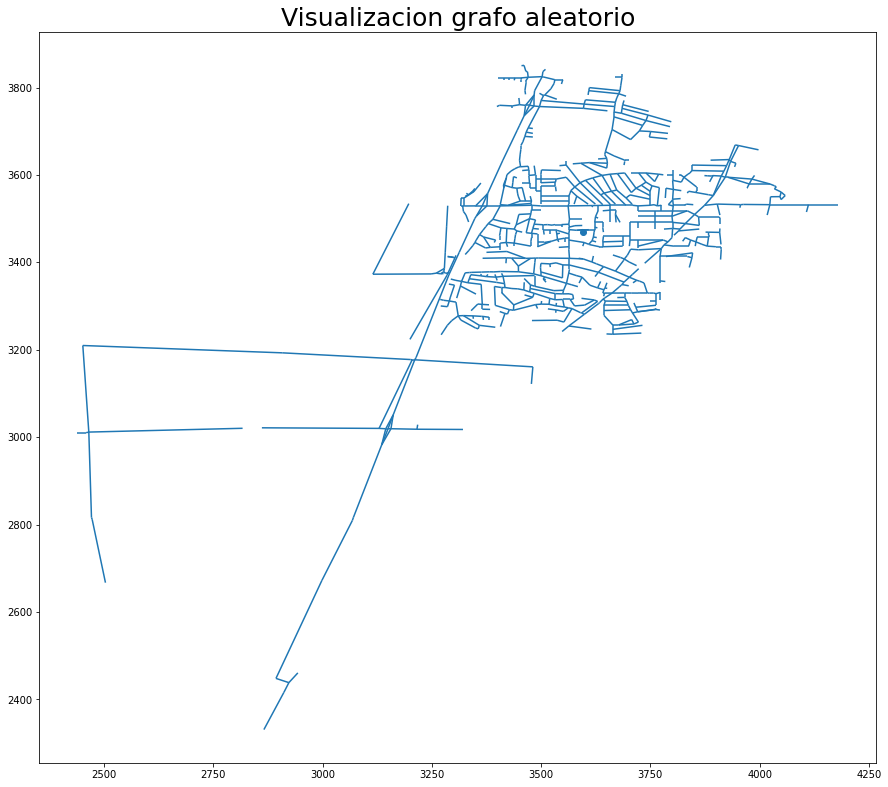

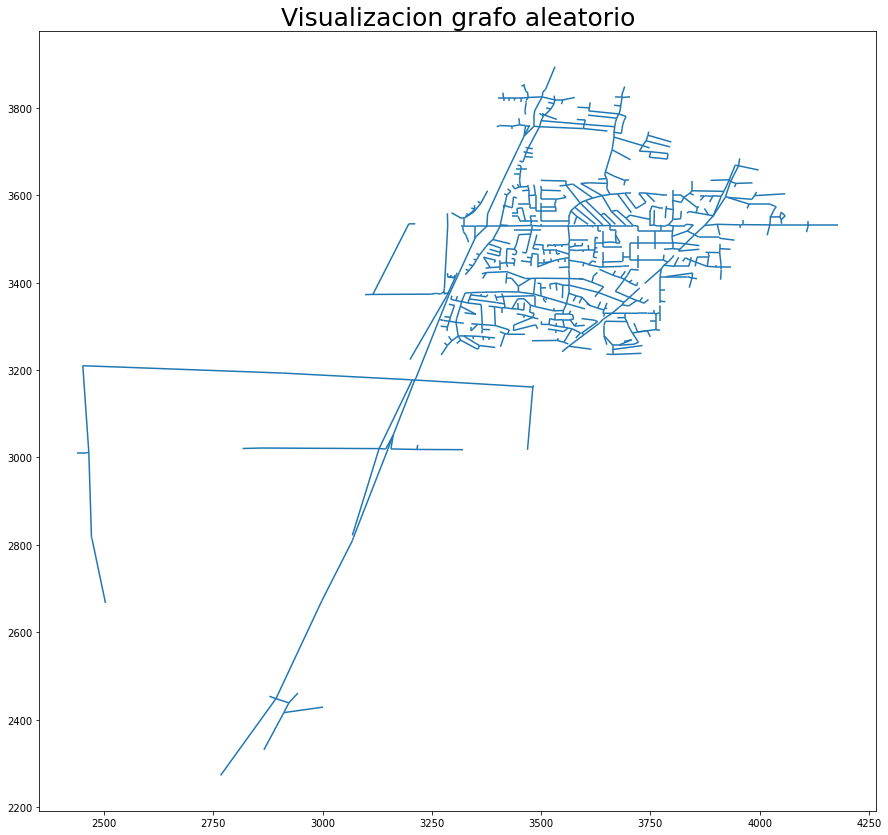

In [82]:
G = G_SJ

g, WTP = generate_random_graph(G_SJ, 1000, nodes_location, 0.05, 5)
plot_random_graph(g, edges_location, nodes_location, WTP)
plot_random_graph2(g, edges_location, nodes_location, WTP)

In [83]:
try:
    print(nx.find_cycle(g.to_undirected()))
except:
    print('no hay ciclos')

print(nx.is_connected(g.to_undirected()))

[(6727, 2081), (2081, 12376), (12376, 18004), (18004, 58), (58, 8583), (8583, 17171), (17171, 2831), (2831, 892), (892, 13621), (13621, 5925), (5925, 6162), (6162, 6257), (6257, 6727)]
True


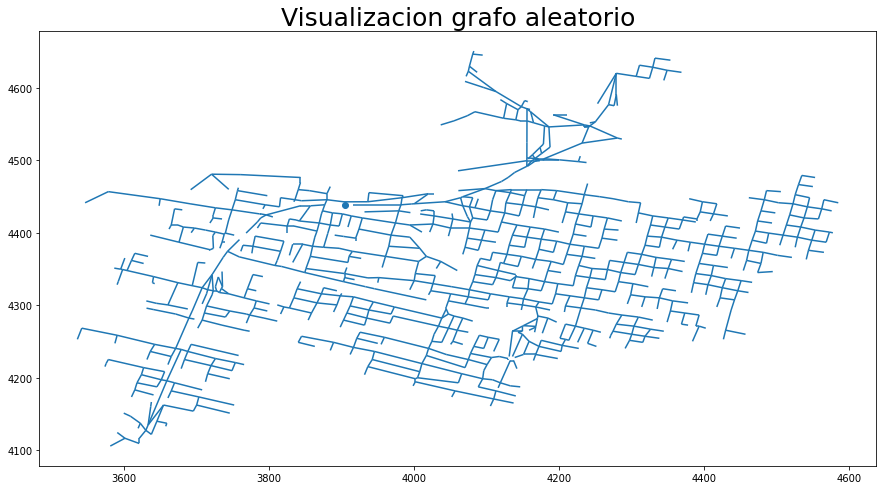

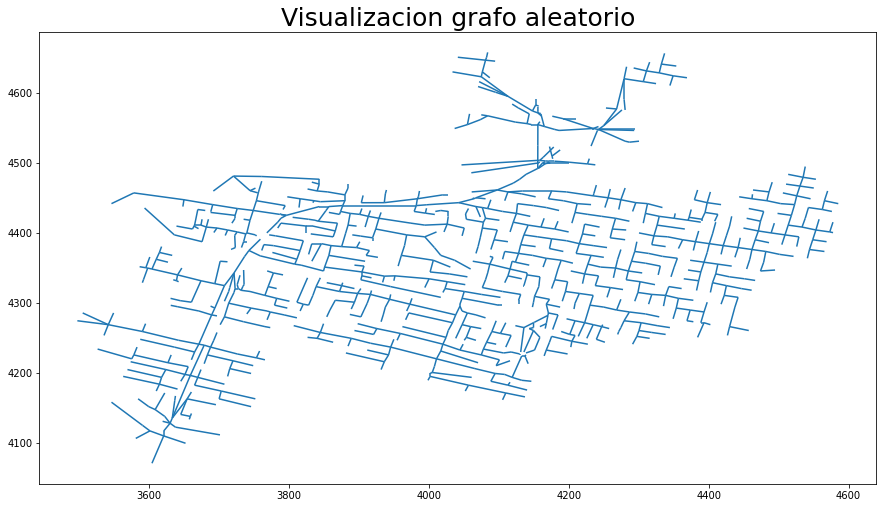

In [85]:
T, WTP = get_random_tree(G_SJ, 1000)
plot_random_graph(T, edges_location, nodes_location, WTP)
plot_random_graph2(T, edges_location, nodes_location, WTP)

In [86]:
try:
    print(nx.find_cycle(T.to_undirected()))
except:
    print('no hay ciclos')

no hay ciclos


In [23]:
len(G_.nodes()), len(G_.edges())

(10, 11)

## Comparación de robustes de ideales en grafos reales y aleatorios

In [238]:
# Idea: para todo nodo registrar el porcentaje de variación entre su ideal normal y robusto
# Se grafica la distribución. Junto con eso, se registra el promedio
# Se hace lo mismo en la instancia real y en la aleatoria. Se comparan resultados.
def get_size_robust(G, V_, node):
    N = len(V_)
    if V_[node]:
        return 0
    if node == root:
        return N - sum(V_)
    V = [0] * N
    V[root] = 1; Q = deque([root]);
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v] and v != node:
                V[v] = 1
                Q.append(v)
    return sum([1 for u in range(N) if V_[u] + V[u] == 0])

### Diferencias de ideales porcentualmente en grafo original

In [ ]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

Promedio de tamano de ideal: 112


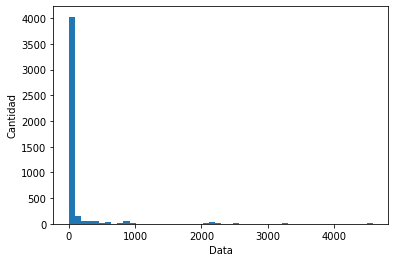

In [722]:
sizes = [get_size(G_SP, [0] * 5000, u) for u in G_SP.nodes()]
sizes.sort()
#pd.Series(sizes).value_counts().plot()
plt.hist(sizes, bins=50)
plt.ylabel('Cantidad')
plt.xlabel('Data')
print(f'Promedio de tamano de ideal: {round(sum(sizes)/len(sizes))}')

In [724]:
nodes_G = list(G_SP.nodes())
root = 744
N = len(nodes_G)
differences_original_1, differences_original_2, differences_original_3 = list(), list(), list()
differences_1, differences_2, differences_3 = split(sizes, 3)
for i in range(len(nodes_G)):
    node = nodes_G[i]
    size = get_size(G, [0] * N , node)
    if size < max(differences_1):
        size_robust = get_size_robust(G, [0] * N , node)
        differences_original_1.append(size_robust / size)
    elif size < max(differences_2):
        size_robust = get_size_robust(G, [0] * N , node)
        differences_original_2.append(size_robust / size)
    else:
        size_robust = get_size_robust(G, [0] * N , node)
        differences_original_3.append(size_robust / size)

Text(0.5, 0, 'Ratio')

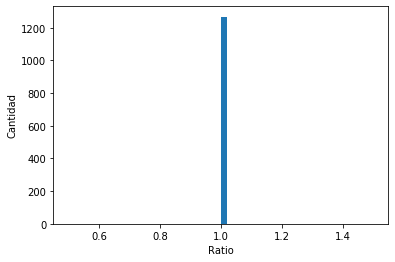

In [725]:
plt.hist(differences_original_1, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Text(0.5, 0, 'Ratio')

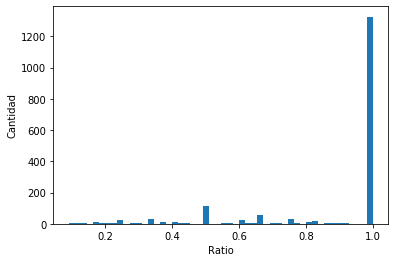

In [726]:
plt.hist(differences_original_2, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Text(0.5, 0, 'Ratio')

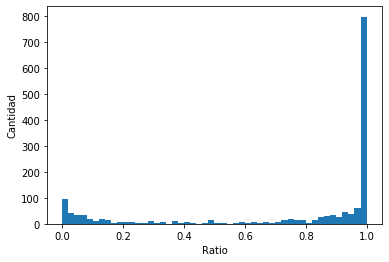

In [727]:
plt.hist(differences_original_3, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Distribuciones de grafo aleatorio

In [774]:
G_, WTP = generate_random_graph(G_SJ, len(G_SP.edges()), nodes_location, 0.05, 5)

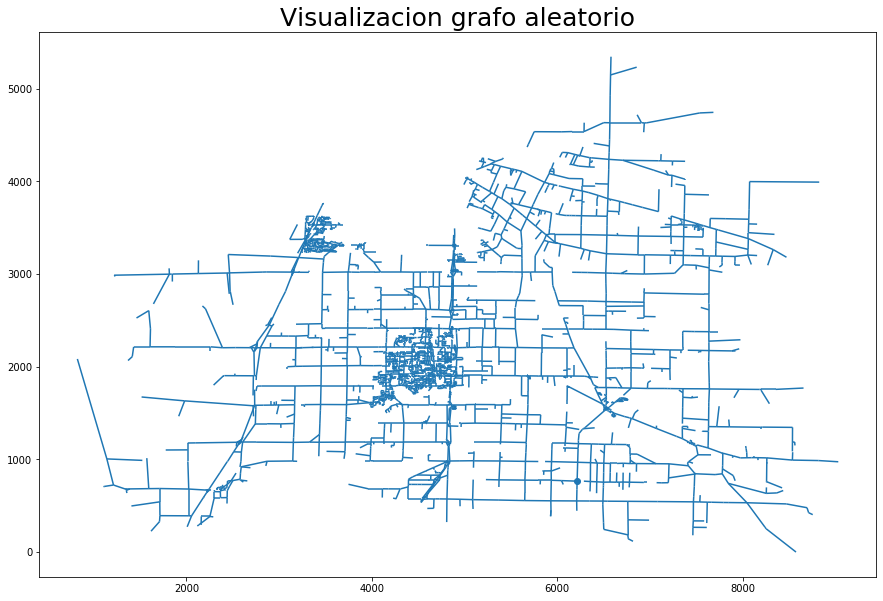

In [775]:
plot_random_graph(G_, edges_location, nodes_location, WTP)

In [777]:
G__ = G_.copy()
S = set()
for origin, dest in G__.edges():
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

        
G_ = nx.DiGraph()
for origin, dest in G__.edges():
    G_.add_edge(id_[origin], id_[dest])
    
Nr = l

Promedio de tamano de ideal: 51


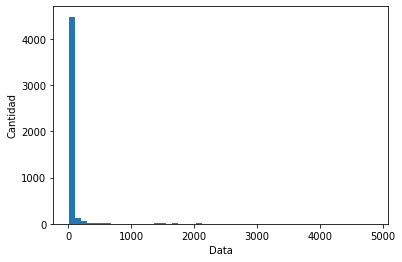

In [778]:
sizes = [get_size(G_, [0] * 20_000, u) for u in G_.nodes()]
sizes.sort()
#pd.Series(sizes).value_counts().plot()
plt.hist(sizes, bins=50)
plt.ylabel('Cantidad')
plt.xlabel('Data')
print(f'Promedio de tamano de ideal: {round(sum(sizes)/len(sizes))}')

In [779]:
nodes_Gr = list(G_.nodes())
Nr = len(nodes_Gr) 
root = id_[WTP]
differences_random = list()
differences_random_1, differences_random_2, differences_random_3 = list(), list(), list()
for i in range(len(nodes_Gr)):
    node = nodes_Gr[i]
    size = get_size(G_, [0] * Nr , node)
    size_robust =  get_size_robust(G_, [0] * Nr , node)
    if size < max(differences_1):
        differences_random_1.append(size_robust / size)
        
    elif size < max(differences_2):
        differences_random_2.append(size_robust / size)
        
    else:
        differences_random_3.append(size_robust / size)

Text(0.5, 0, 'Ratio')

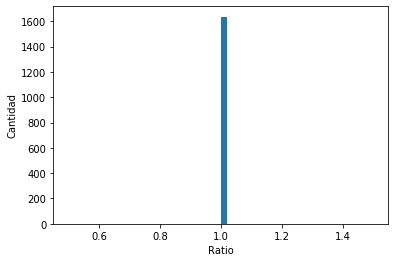

In [780]:
plt.hist(differences_random_1, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Text(0.5, 0, 'Ratio')

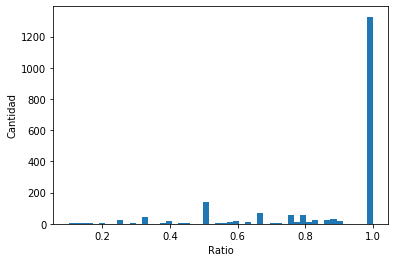

In [781]:
plt.hist(differences_random_2, bins=50)  # density=False would make counts
plt.ylabel('Cantidad')
plt.xlabel('Ratio')

Text(0.5, 0, 'Ratio')

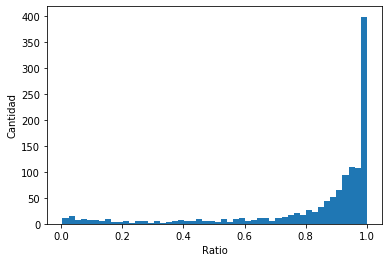

In [782]:
plt.hist(differences_random_3, bins=50)  
plt.ylabel('Cantidad')
plt.xlabel('Ratio')